Successfully loaded earthquake_data_tsunami.csv
Dropped 0 rows with missing data.
Data prepared: 782 samples, 10 features.
Training classifier on 547 samples...

--- Results for From-Scratch Classifier (All Features) ---
Accuracy: 76.60%
Confusion Matrix:
 [[109  35]
 [ 20  71]]
-------------------------------------------------------
Generating Confusion Matrix heatmap...


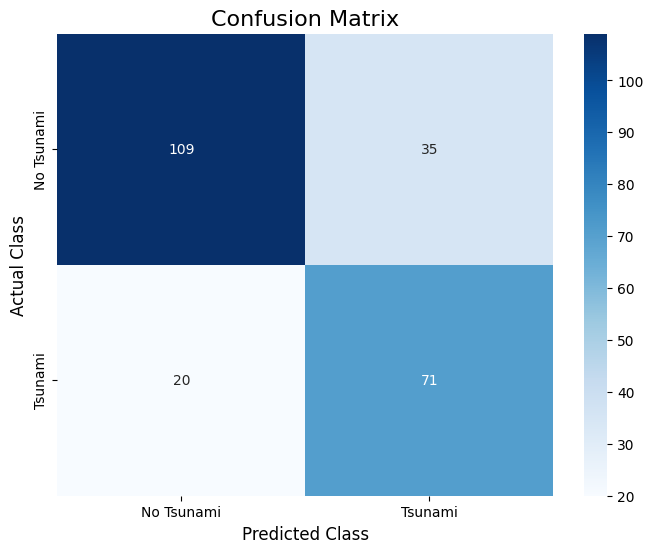

Generating 2D Decision Boundary plot (using 'magnitude' and 'depth')...


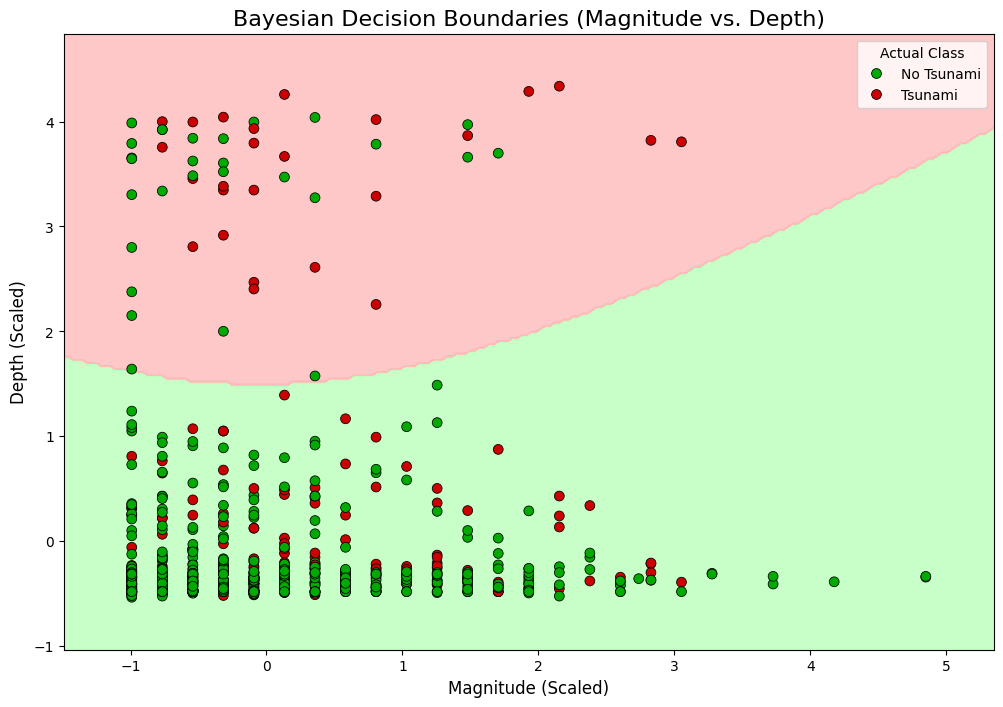


Analysis complete.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# --------------------------
# 1. Gaussian Naive Bayes Classifier (From Scratch)
# --------------------------
class GaussianNaiveBayes:
    """
    Implements Gaussian Naive Bayes based on Bayesian Decision Theory.
    Assumes features are conditionally independent (Naive) and
    normally distributed (Gaussian).
    """

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # Calculate mean, variance, and prior for each class
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            # Add a small epsilon (1e-9) for numerical stability
            # This prevents division-by-zero if a feature has zero variance for a class
            self._var[idx, :] = X_c.var(axis=0) + 1e-9
            # Prior P(w_i) is the frequency of the class
            self._priors[idx] = X_c.shape[0] / float(n_samples)

    def _pdf(self, class_idx, x):
        """
        Calculate 1D Gaussian Probability Density Function (Likelihood of one feature)
        P(x_j | w_i)
        """
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(- (x - mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

    def _predict_sample(self, x):
        """
        Predict the class for a single sample x using Bayesian Decision Rule.
        Finds argmax_i P(w_i | x) = argmax_i [ log(P(w_i)) + sum(log(P(x_j | w_i))) ]
        """
        posteriors = []

        for idx, c in enumerate(self._classes):
            # Log of the prior P(w_i)
            prior = np.log(self._priors[idx])

            # Sum of the logs of the likelihoods P(x_j | w_i) for all features j
            likelihoods = self._pdf(idx, x)
            class_conditional = np.sum(np.log(likelihoods + 1e-9)) # Epsilon for log(0)

            # Posterior probability (proportional to)
            posterior = prior + class_conditional
            posteriors.append(posterior)

        # Decision: return the class with the highest posterior probability
        return self._classes[np.argmax(posteriors)]

    def predict(self, X):
        """Predict the class for a set of samples X."""
        y_pred = [self._predict_sample(x) for x in X]
        return np.array(y_pred)

# --------------------------
# 2. Load and Prepare Data
# --------------------------
try:
    df = pd.read_csv("earthquake_data_tsunami.csv")
    print("Successfully loaded earthquake_data_tsunami.csv")
except FileNotFoundError:
    print("Error: earthquake_data_tsunami.csv not found.")
    print("Please make sure the file is in the same directory as the script.")
    exit()

# Define features (X) and target (y)
# We'll exclude Year and Month as they are unlikely to be causal
features_list = ['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude']
target = 'tsunami'

# Preprocessing: Drop rows with any missing values
original_count = len(df)
df.dropna(subset=features_list + [target], inplace=True)
print(f"Dropped {original_count - len(df)} rows with missing data.")

# Separate features and target
X_raw = df[features_list].values
y = df[target].values

# Preprocessing: Scale features
# This is crucial for Gaussian Naive Bayes, as it assumes data is normally distributed.
# Scaling helps to center the data (mean=0, var=1).
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

print(f"Data prepared: {X.shape[0]} samples, {X.shape[1]} features.")

# --------------------------
# 3. Train and Evaluate Classifier (All Features)
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training classifier on {len(X_train)} samples...")
gnb_classifier = GaussianNaiveBayes()
gnb_classifier.fit(X_train, y_train)
y_pred = gnb_classifier.predict(X_test)

# Print results
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
class_names = ['No Tsunami', 'Tsunami']

print(f"\n--- Results for From-Scratch Classifier (All Features) ---")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", cm)
print("-" * 55)

# --------------------------
# 4. Graphical Representation 1: Confusion Matrix Heatmap
# --------------------------
print("Generating Confusion Matrix heatmap...")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.show()

# --------------------------
# 5. Graphical Representation 2: 2D Decision Boundaries
# --------------------------
print("Generating 2D Decision Boundary plot (using 'magnitude' and 'depth')...")

# We'll re-train a separate classifier on just these two features for visualization
vis_features = ['magnitude', 'depth']
X_vis_raw = df[vis_features].values
X_vis = StandardScaler().fit_transform(X_vis_raw)
y_vis = y

# Train the visualization classifier
gnb_vis = GaussianNaiveBayes()
gnb_vis.fit(X_vis, y_vis)

# Create a meshgrid to plot the decision boundaries
x_min, x_max = X_vis[:, 0].min() - 0.5, X_vis[:, 0].max() + 0.5
y_min, y_max = X_vis[:, 1].min() - 0.5, X_vis[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Get predictions for every point on the grid
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = gnb_vis.predict(grid_points)
Z = Z.reshape(xx.shape)

# Setup plot
plt.figure(figsize=(12, 8))
cmap_light = ListedColormap(['#BBFFBB', '#FFBBBB']) # Green for 'No Tsunami', Red for 'Tsunami'
cmap_bold = ['#00AA00', '#CC0000']

# Plot the decision boundaries
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)

# Plot the actual data points
sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1], hue=y_vis,
                palette=cmap_bold, alpha=1.0, edgecolor="k", s=50)

plt.title("Bayesian Decision Boundaries (Magnitude vs. Depth)", fontsize=16)
plt.xlabel("Magnitude (Scaled)", fontsize=12)
plt.ylabel("Depth (Scaled)", fontsize=12)
# Create custom legend labels
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['No Tsunami', 'Tsunami'], title="Actual Class")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

print("\nAnalysis complete.")